In [3]:
# Required imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from PIL import Image
import random
import json
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


In [4]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Function to load JSON data
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [6]:
# Function to prepare data from JSON
def prepare_dataframe(data):
    corrected_data = []
    for item in data:
        corrected_item = {key.replace(':', '').strip(): value for key, value in item.items()}
        corrected_data.append(corrected_item)
    return corrected_data

In [7]:
# Group images by brand
def group_images_by_brand(data):
    grouped = {}
    for item in data:
        brand = item['Brand']
        image_path = item['Image Path']
        if brand in grouped:
            grouped[brand].append(image_path)
        else:
            grouped[brand] = [image_path]
    return grouped

In [8]:
def split_images_exclusively(grouped_images, train_frac=0.7, val_frac=0.15, test_frac=0.15, min_images=3):
    train_images, val_images, test_images = {}, {}, {}
    for brand, images in grouped_images.items():
        if len(images) < min_images:
            continue  # Skip brands with fewer images than the minimum required to form triplets

        random.shuffle(images)
        n = len(images)
        train_end = int(n * train_frac)
        val_end = train_end + int(n * val_frac)

        train_images[brand] = images[:train_end]
        val_images[brand] = images[train_end:val_end]
        test_images[brand] = images[val_end:]

    return train_images, val_images, test_images


In [10]:
# Load and prepare data
data = load_json_data('scraping_output/updated_completed_log.json')

data = prepare_dataframe(data)
grouped_images = group_images_by_brand(data)

In [11]:
def split_grouped_images(grouped_images, train_frac=0.7, val_frac=0.15):
    train_data, val_data, test_data = {}, {}, {}
    for brand, images in grouped_images.items():
        random.shuffle(images)
        n_total = len(images)
        n_train = int(n_total * train_frac)
        n_val = int(n_total * val_frac)
        train_data[brand] = images[:n_train]
        val_data[brand] = images[n_train:n_train + n_val]
        test_data[brand] = images[n_train + n_val:]
    return train_data, val_data, test_data


In [12]:
def generate_all_triplets(grouped_images, min_images_per_brand=3):
    triplets = []
    for brand, images in grouped_images.items():
        # Ensure there are enough images to form a triplet
        if len(images) < 2:
            continue  # Need at least two images to form a positive pair

        # Find suitable brands for negative examples
        suitable_brands = [b for b in grouped_images if b != brand and len(grouped_images[b]) >= 1]
        if not suitable_brands:
            continue  # No suitable brands for negative examples

        # Generate triplets
        for _ in range(10):  # Adjust number as needed
            anchor, positive = random.sample(images, 2)
            negative_brand = random.choice(suitable_brands)
            negative = random.choice(grouped_images[negative_brand])
            triplets.append((anchor, positive, negative))
    return triplets


In [13]:
def split_triplets(triplets, train_frac=0.7, val_frac=0.15):
    random.shuffle(triplets)  # Shuffle triplets
    total_count = len(triplets)
    train_end = int(total_count * train_frac)
    val_end = train_end + int(total_count * val_frac)

    train_triplets = triplets[:train_end]
    val_triplets = triplets[train_end:val_end]
    test_triplets = triplets[val_end:]

    return train_triplets, val_triplets, test_triplets


In [14]:
class TripletWatchDataset(Dataset):
    def __init__(self, triplets, transform=None):
        self.triplets = triplets
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        return (self.load_image(anchor), self.load_image(positive), self.load_image(negative))

    def __len__(self):
        return len(self.triplets)

    def load_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [15]:
# Define the WatchEmbeddingModel using VGG16
class WatchEmbeddingModel(nn.Module):
    def __init__(self, embedding_size=600):
        super(WatchEmbeddingModel, self).__init__()
        base_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.features = base_model.features
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, embedding_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [16]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_losses = []
    val_losses = []

    plt.figure(figsize=(10, 5))

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for batch_idx, (anchors, positives, negatives) in enumerate(train_loader):
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            optimizer.zero_grad()
            anchor_out = model(anchors)
            positive_out = model(positives)
            negative_out = model(negatives)
            train_loss = criterion(anchor_out, positive_out, negative_out)
            train_loss.backward()
            optimizer.step()

            # Validation phase within the same loop to plot validation loss
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for val_anchors, val_positives, val_negatives in val_loader:
                    val_anchors, val_positives, val_negatives = val_anchors.to(device), val_positives.to(device), val_negatives.to(device)
                    val_anchor_out = model(val_anchors)
                    val_positive_out = model(val_positives)
                    val_negative_out = model(val_negatives)
                    val_loss = criterion(val_anchor_out, val_positive_out, val_negative_out)
                    break  # Break after one batch for quick validation estimation

            # Append losses for plotting
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

            # Update plot
            clear_output(wait=True)
            plt.plot(train_losses, label='Train Loss', color='blue')
            plt.plot(val_losses, label='Validation Loss', color='red')
            plt.title('Training and Validation Loss')
            plt.xlabel('Batch Number')
            plt.ylabel('Loss')
            plt.legend()
            plt.pause(0.01)

        # Print epoch loss
        print(f'Epoch {epoch + 1}/{num_epochs}: Last Train Loss: {train_loss.item():.4f}, Last Val Loss: {val_loss.item():.4f}')

    plt.ioff()  # Turn off interactive mode
    plt.show()



In [17]:

def evaluate_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            emb = model(images).cpu()
            embeddings.append(emb)
    embeddings = torch.cat(embeddings).numpy()
    n_clusters = min(5, len(embeddings) // 20)
    if n_clusters > 1:
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(embeddings)
        silhouette_sc = silhouette_score(embeddings, labels)  # Rename variable here
        print(f"Silhouette Score: {silhouette_sc}")
        return silhouette_sc
    else:
        print("Not enough data to evaluate using silhouette score.")
        return None


In [18]:
def plot_training_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.title('Training Loss Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def get_optimizer(model, learning_rate=0.0001):
    # Use the Adam optimizer with the given learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return optimizer


KeyboardInterrupt: 

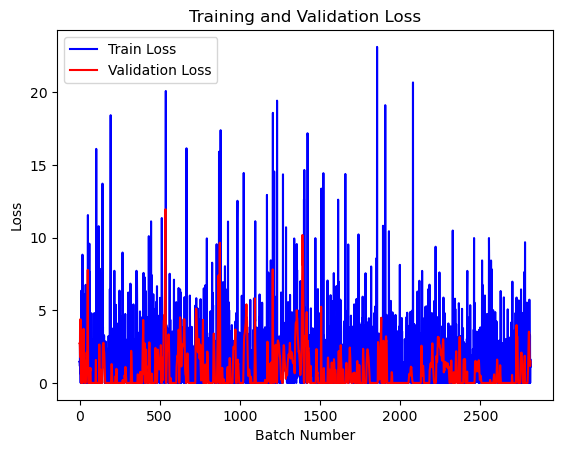

In [21]:
# Load and prepare data
data = load_json_data('scraping_output/updated_completed_log.json')

data = prepare_dataframe(data)
grouped_images = group_images_by_brand(data)

# Generate all possible triplets
all_triplets = generate_all_triplets(grouped_images)

# Shuffle and split the triplets
random.shuffle(all_triplets)  # This should now work without error
train_triplets, val_triplets, test_triplets = split_triplets(all_triplets)

# Initialize datasets with the correct constructor
train_dataset = TripletWatchDataset(train_triplets)
val_dataset = TripletWatchDataset(val_triplets)
test_dataset = TripletWatchDataset(test_triplets)

def check_image_overlap(train_dataset, val_dataset):
    train_images = set()
    val_images = set()

    for triplets in train_dataset.triplets:
        train_images.update(triplets)  # Add all images from each triplet

    for triplets in val_dataset.triplets:
        val_images.update(triplets)  # Add all images from each triplet

    overlap = train_images.intersection(val_images)
    return overlap

# Assuming you have already loaded your datasets:
overlap_images = check_image_overlap(train_dataset, val_dataset)
print(f"Overlapping images: {len(overlap_images)}")


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Define the loss function with a specific margin
criterion = nn.TripletMarginLoss(margin=2, p=2)  # p=2 denotes Euclidean distance


# Set the number of epochs
num_epochs = 10



# Instantiate the model and setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WatchEmbeddingModel(embedding_size=600)
optimizer = get_optimizer(model, learning_rate=0.0001)
criterion = nn.TripletMarginLoss(margin=3.0, p=2)

# Suppose train_loader and val_loader are already defined
num_epochs = 10
train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_path  # Ensure this returns only two items


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


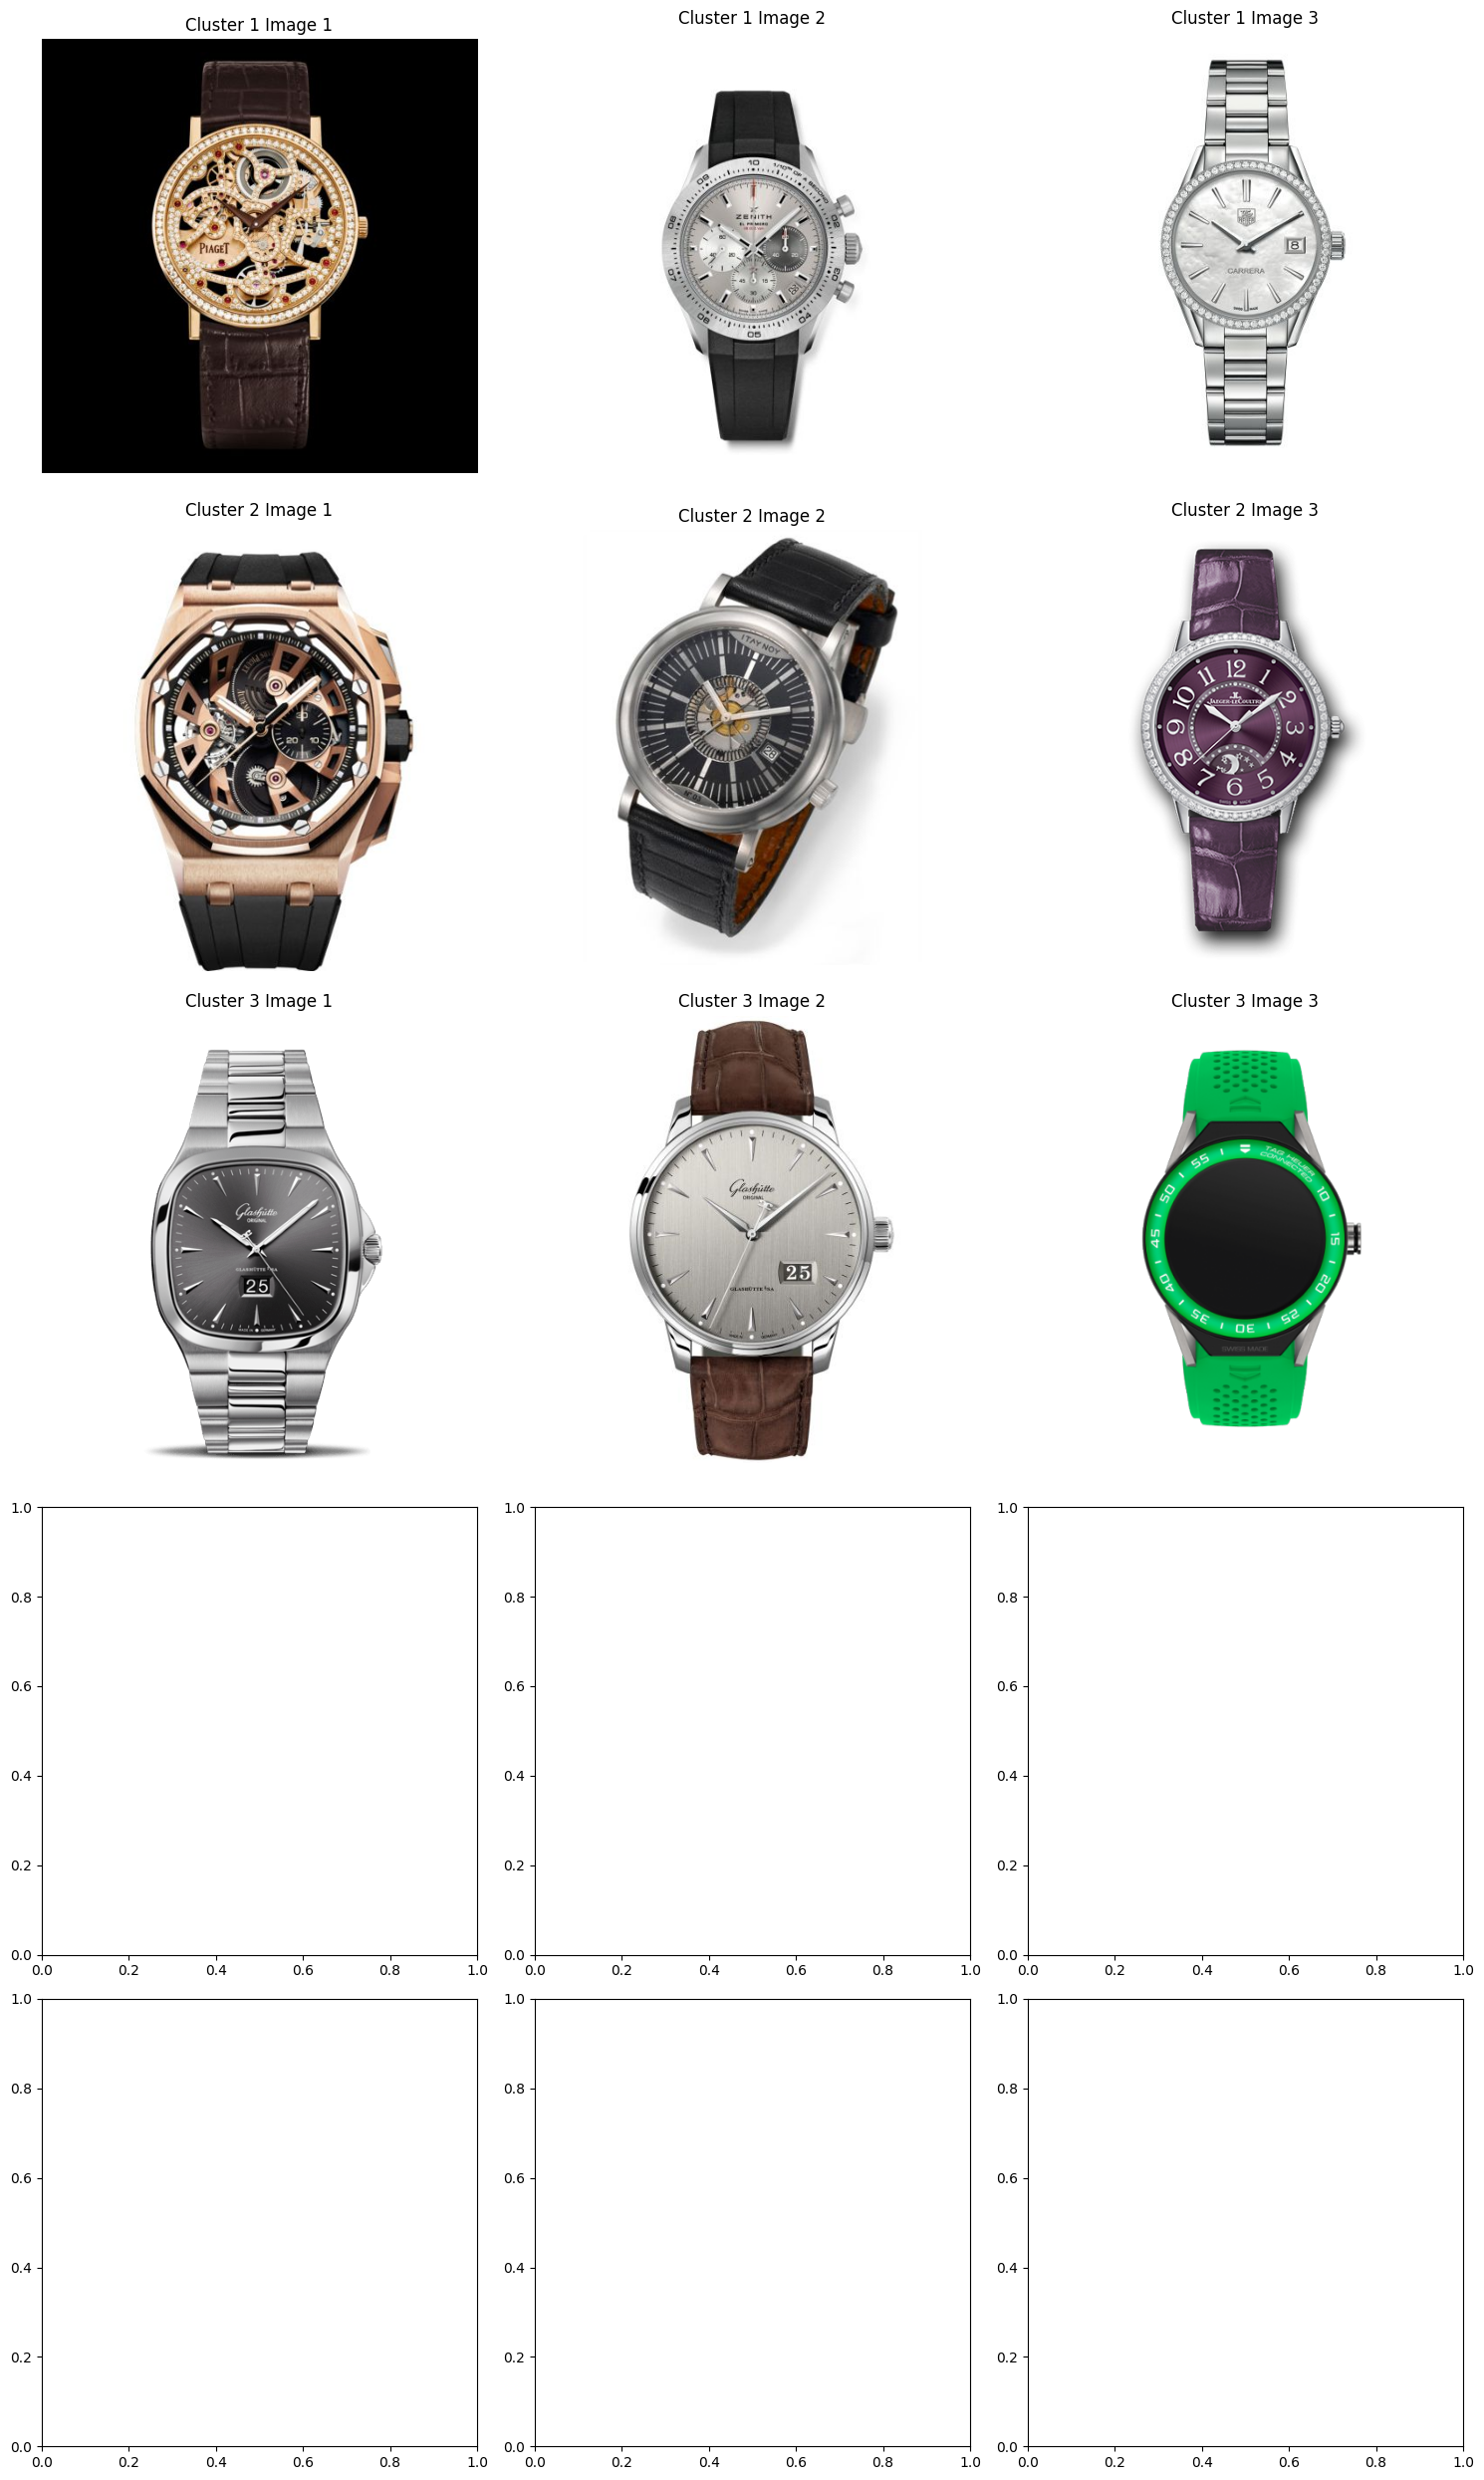

In [ ]:
import os
import random
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
from torchvision import transforms

def load_data(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data


def extract_features(data, model, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    features = []
    with torch.no_grad():
        for item in data:
            img_path = item['Image Path']
            image = Image.open(img_path).convert('RGB')
            image = transform(image).unsqueeze(0).to(device)
            feature = model(image)
            features.append(feature.flatten().cpu().numpy())
    return features

def balanced_cluster_data(features, num_clusters=3):
    # Attempt to create balanced clusters by iterating until a satisfactory clustering is found
    satisfied = False
    max_attempts = 15
    attempt = 0
    while not satisfied and attempt < max_attempts:
        kmeans = KMeans(n_clusters=num_clusters, random_state=attempt)
        labels = kmeans.fit_predict(features)
        cluster_sizes = [list(labels).count(i) for i in range(num_clusters)]
        if all(size >= 3 for size in cluster_sizes):
            satisfied = True
        attempt += 1
    return labels if satisfied else None  # Return None if no satisfactory clustering found

def display_clustered_images(data, labels, num_clusters=5):
    # Determine the number of images per cluster to display
    images_per_cluster = 3
    # Create a subplot for each cluster and for up to three images per cluster
    fig, axs = plt.subplots(num_clusters, images_per_cluster, figsize=(15, 5 * num_clusters), squeeze=False)
    
    for i in range(num_clusters):
        cluster_indices = [idx for idx, label in enumerate(labels) if label == i]
        for j in range(min(images_per_cluster, len(cluster_indices))):
            img_path = data[cluster_indices[j]]['Image Path']
            image = Image.open(img_path)
            ax = axs[i, j]
            ax.imshow(image)
            ax.set_title(f'Cluster {i+1} Image {j+1}')
            ax.axis('off')
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_path = 'scraping_output/cleaned_watches.json'
    # Load and select data
    watches_data = load_data(data_path)
    selected_watches = random.sample(watches_data, min(len(watches_data), 500))  # Increased sample size

    # Load the trained model and extract features
    watch_features = extract_features(selected_watches, model, device)

    # Cluster and display
    cluster_labels = balanced_cluster_data(watch_features)
    if cluster_labels is not None:
        display_clustered_images(selected_watches, cluster_labels)
    else:
        print("Failed to find a satisfactory clustering with the minimum size in each cluster.")
